# Phase 3 — XGBoost Fraud Detection Model
**Inputs:** `X_train_fe.csv`, `y_train_fe.csv` (Phase 2) · `X_test.csv`, `y_test.csv` (Phase 1)  
**Goal:** Baseline Logistic Regression → XGBoost → Evaluation → Cost analysis → SHAP  
**Constraints:** No SMOTE · No random split · No leakage · No hyperparameter search

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

X_train_fe = pd.read_csv("data/processed/X_train_fe.csv")
y_train_fe = pd.read_csv("data/processed/y_train_fe.csv")
X_test_raw = pd.read_csv("data/processed/X_test.csv")
y_test     = pd.read_csv("data/processed/y_test.csv")

scaling_params = pd.read_csv("data/processed/train_scaling_params.csv").iloc[0]
MEAN_AMOUNT = scaling_params["mean_amount"]
STD_AMOUNT  = scaling_params["std_amount"]

FEATURE_COLS = list(X_train_fe.columns)

print(f"X_train_fe : {X_train_fe.shape}  |  fraud={y_train_fe['Class'].mean()*100:.4f}%")
print(f"X_test_raw : {X_test_raw.shape}  |  fraud={y_test['Class'].mean()*100:.4f}%")
print(f"Scaling    : mean={MEAN_AMOUNT:.4f}  std={STD_AMOUNT:.4f}")
print(f"Features   : {FEATURE_COLS}")


X_train_fe : (227843, 39)  |  fraud=0.1830%
X_test_raw : (56962, 30)  |  fraud=0.1317%
Scaling    : mean=90.8249  std=250.5032
Features   : ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'log_amount', 'amount_zscore_global', 'rolling_mean_amount', 'rolling_std_amount', 'time_diff', 'amount_deviation', 'amount_zscore_rolling', 'rolling_fraud_count_500', 'rolling_fraud_rate_500']


## Step 1 — Apply Feature Engineering to Test Set

The identical transformation pipeline from Phase 2 is applied to the test set.

**Leakage rules enforced:**
- Amount normalisation uses `mean_amount` / `std_amount` from **train only** (loaded above).
- Rolling windows on the test set use only past test rows (`.shift(1)` before `.rolling()`).
- The test set is never mixed with training data.
- NaN rows from rolling cold-start are dropped.

In [2]:
def apply_feature_pipeline(df_raw, y_raw, mean_amount, std_amount,
                           window_amount=100, window_fraud=500):
    """Reproduce the Phase 2 feature pipeline on any split. Uses train-only
    scaling constants — never recomputes them from df_raw."""
    df = df_raw.copy()
    df["Class"] = y_raw["Class"].values
    df = df.sort_values("Time").reset_index(drop=True)

    df["log_amount"]            = np.log1p(df["Amount"])
    df["amount_zscore_global"]  = (df["Amount"] - mean_amount) / std_amount

    amt_s = df["Amount"].shift(1)
    df["rolling_mean_amount"] = amt_s.rolling(window_amount, min_periods=1).mean()
    df["rolling_std_amount"]  = amt_s.rolling(window_amount, min_periods=2).std(ddof=1)
    df["time_diff"]           = df["Time"] - df["Time"].shift(1)

    df["amount_deviation"]      = df["Amount"] - df["rolling_mean_amount"]
    std_safe                    = df["rolling_std_amount"].replace(0, np.nan)
    df["amount_zscore_rolling"] = df["amount_deviation"] / std_safe

    cls_s = df["Class"].shift(1)
    df["rolling_fraud_count_500"] = cls_s.rolling(window_fraud, min_periods=1).sum()
    df["rolling_fraud_rate_500"]  = cls_s.rolling(window_fraud, min_periods=1).mean()

    ENGINEERED_COLS = [
        "log_amount", "amount_zscore_global",
        "rolling_mean_amount", "rolling_std_amount", "time_diff",
        "amount_deviation", "amount_zscore_rolling",
        "rolling_fraud_count_500", "rolling_fraud_rate_500",
    ]
    all_cols   = list(df_raw.columns) + ENGINEERED_COLS
    feature_df = df[all_cols + ["Class"]].dropna().reset_index(drop=True)
    return feature_df[all_cols], feature_df[["Class"]]


X_test_fe, y_test_fe = apply_feature_pipeline(
    X_test_raw, y_test, mean_amount=MEAN_AMOUNT, std_amount=STD_AMOUNT
)
X_test_fe = X_test_fe[FEATURE_COLS]   # align column order to train

print(f"X_train_fe : {X_train_fe.shape}  |  fraud={y_train_fe['Class'].mean()*100:.4f}%")
print(f"X_test_fe  : {X_test_fe.shape}   |  fraud={y_test_fe['Class'].mean()*100:.4f}%")
print(f"Column sets match: {set(X_train_fe.columns) == set(X_test_fe.columns)}")


X_train_fe : (227843, 39)  |  fraud=0.1830%
X_test_fe  : (56960, 39)   |  fraud=0.1317%
Column sets match: True


## Step 2 — Baseline Logistic Regression

`class_weight="balanced"` compensates for the severe class imbalance (~0.17% fraud) without SMOTE.  
StandardScaler is applied **inside** the pipeline so the test set is transformed using train statistics only — no leakage.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix,
    roc_curve, precision_recall_curve,
)

# StandardScaler inside the pipeline — test set sees only train statistics
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        class_weight="balanced", max_iter=1000,
        random_state=42, solver="lbfgs", n_jobs=-1,
    )),
])

y_tr = y_train_fe["Class"].values
y_te = y_test_fe["Class"].values

lr_pipeline.fit(X_train_fe, y_tr)

lr_proba = lr_pipeline.predict_proba(X_test_fe)[:, 1]
lr_pred  = lr_pipeline.predict(X_test_fe)

lr_roc_auc = roc_auc_score(y_te, lr_proba)
lr_pr_auc  = average_precision_score(y_te, lr_proba)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, lr_pred, pos_label=1, average="binary")
tn, fp_lr, fn_lr, tp = confusion_matrix(y_te, lr_pred).ravel()

print(f"Logistic Regression — Test Set")
print(f"  ROC-AUC={lr_roc_auc:.4f}  PR-AUC={lr_pr_auc:.4f}  Recall={rec:.4f}  Precision={prec:.4f}  F1={f1:.4f}")
print(f"  TN={tn:,}  FP={fp_lr:,}  FN={fn_lr:,}  TP={tp:,}")


Logistic Regression — Test Set
  ROC-AUC=0.9861  PR-AUC=0.7597  Recall=0.9067  Precision=0.0554  F1=0.1045
  TN=55,726  FP=1,159  FN=7  TP=68


## Step 3 — XGBoost Model

**Validation split:** last 20% of the (already time-ordered) training set.  
This mirrors the temporal structure of the train/test split — no shuffling, no random split.

`scale_pos_weight` = negatives / positives in train, directing XGBoost to penalise missed fraud proportionally to class imbalance — without SMOTE.

In [4]:
from xgboost import XGBClassifier

# temporal val split — last 20% of train, mirrors the train/test split logic
val_cutoff = int(len(X_train_fe) * 0.80)
X_tr_xgb   = X_train_fe.iloc[:val_cutoff]
y_tr_xgb   = y_tr[:val_cutoff]
X_val_xgb  = X_train_fe.iloc[val_cutoff:]
y_val_xgb  = y_tr[val_cutoff:]

spw = (y_tr_xgb == 0).sum() / (y_tr_xgb == 1).sum()
print(f"Train subset: {X_tr_xgb.shape}  Val subset: {X_val_xgb.shape}  SPW={spw:.2f}")

xgb_model = XGBClassifier(
    objective="binary:logistic", eval_metric="aucpr",
    scale_pos_weight=spw,
    max_depth=6, learning_rate=0.05, n_estimators=500,
    early_stopping_rounds=50, subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, verbosity=0,
)
xgb_model.fit(X_tr_xgb, y_tr_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)
print(f"Best iteration: {xgb_model.best_iteration}")

xgb_proba = xgb_model.predict_proba(X_test_fe)[:, 1]
xgb_pred  = (xgb_proba >= 0.5).astype(int)

xgb_roc_auc = roc_auc_score(y_te, xgb_proba)
xgb_pr_auc  = average_precision_score(y_te, xgb_proba)
prec_x, rec_x, f1_x, _ = precision_recall_fscore_support(y_te, xgb_pred, pos_label=1, average="binary")
tn_x, fp_x, fn_x, tp_x = confusion_matrix(y_te, xgb_pred).ravel()

print(f"\nXGBoost — Test Set")
print(f"  ROC-AUC={xgb_roc_auc:.4f}  PR-AUC={xgb_pr_auc:.4f}  Recall={rec_x:.4f}  Precision={prec_x:.4f}  F1={f1_x:.4f}")
print(f"  TN={tn_x:,}  FP={fp_x:,}  FN={fn_x:,}  TP={tp_x:,}")


Train subset: (182274, 39)  Val subset: (45569, 39)  SPW=498.38
Best iteration: 97

XGBoost — Test Set
  ROC-AUC=0.9681  PR-AUC=0.7942  Recall=0.7600  Precision=0.8769  F1=0.8143
  TN=56,877  FP=8  FN=18  TP=57


## Step 4 — Proper Evaluation Metrics

**Recall @ 1% FPR:** In fraud detection, business teams often operate at a fixed false-positive rate budget (e.g. 1% of legitimate transactions flagged). Recall at that operating point tells us what fraction of actual fraud we catch under that budget.

**Method:** Traverse the ROC curve to find the threshold where FPR ≈ 0.01, then compute recall (TPR) at that threshold.

Recall @ 1% FPR
  Model                     Recall   Precision   Threshold
  Logistic Regression       0.8667      0.0893      0.8736
  XGBoost                   0.8667      0.0409      0.0556


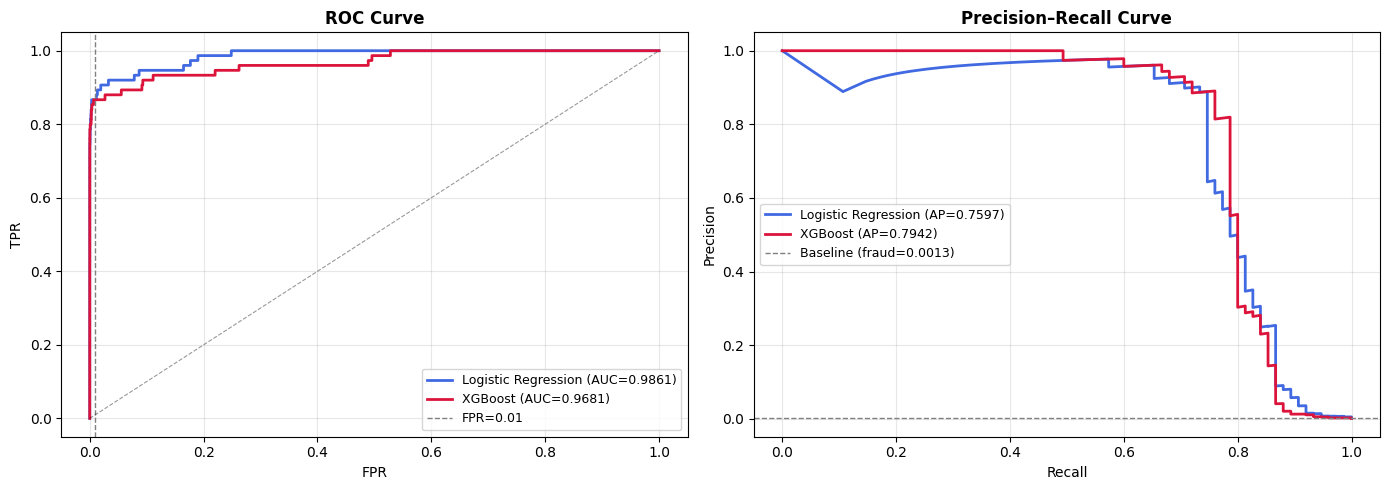

In [5]:
def recall_at_fpr(y_true, y_proba, target_fpr=0.01):
    """Return (recall, precision, threshold, actual_fpr) at the operating point
    where FPR first exceeds target_fpr on the ROC curve."""
    fpr_arr, tpr_arr, thresh_arr = roc_curve(y_true, y_proba)
    idx = max(0, min(np.searchsorted(fpr_arr, target_fpr, side="right") - 1,
                     len(thresh_arr) - 1))
    threshold  = thresh_arr[idx]
    recall_val = tpr_arr[idx]
    actual_fpr = fpr_arr[idx]
    prec_arr, rec_arr, _ = precision_recall_curve(y_true, y_proba)
    prec_val = prec_arr[np.argmin(np.abs(rec_arr - recall_val))]
    return recall_val, prec_val, threshold, actual_fpr


TARGET_FPR = 0.01

lr_rec_fpr,  lr_prec_fpr,  lr_thresh,  lr_actual_fpr  = recall_at_fpr(y_te, lr_proba)
xgb_rec_fpr, xgb_prec_fpr, xgb_thresh, xgb_actual_fpr = recall_at_fpr(y_te, xgb_proba)

print(f"Recall @ {TARGET_FPR*100:.0f}% FPR")
print(f"  {'Model':<22}  {'Recall':>8}  {'Precision':>10}  {'Threshold':>10}")
print(f"  {'Logistic Regression':<22}  {lr_rec_fpr:>8.4f}  {lr_prec_fpr:>10.4f}  {lr_thresh:>10.4f}")
print(f"  {'XGBoost':<22}  {xgb_rec_fpr:>8.4f}  {xgb_prec_fpr:>10.4f}  {xgb_thresh:>10.4f}")

# ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for label, y_prob, color in [("Logistic Regression", lr_proba, "royalblue"),
                              ("XGBoost", xgb_proba, "crimson")]:
    fp, tp, _ = roc_curve(y_te, y_prob)
    p, r, _   = precision_recall_curve(y_te, y_prob)
    axes[0].plot(fp, tp, label=f"{label} (AUC={roc_auc_score(y_te, y_prob):.4f})", color=color, lw=2)
    axes[1].plot(r, p,   label=f"{label} (AP={average_precision_score(y_te, y_prob):.4f})", color=color, lw=2)

axes[0].axvline(TARGET_FPR, color="gray", linestyle="--", lw=1, label=f"FPR={TARGET_FPR}")
axes[0].plot([0, 1], [0, 1], "k--", lw=0.8, alpha=0.4)
axes[0].set_title("ROC Curve", fontweight="bold")
axes[0].set_xlabel("FPR"); axes[0].set_ylabel("TPR")
axes[0].legend(fontsize=9); axes[0].grid(alpha=0.3)

axes[1].axhline(y_te.mean(), color="gray", linestyle="--", lw=1,
                label=f"Baseline (fraud={y_te.mean():.4f})")
axes[1].set_title("Precision–Recall Curve", fontweight="bold")
axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
axes[1].legend(fontsize=9); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("data/processed/roc_pr_curves.png", dpi=150, bbox_inches="tight")
plt.show()


## Step 5 — Cost-Based Evaluation

$$\text{Total Cost} = (\text{FN} \times €200) + (\text{FP} \times €5)$$

- **FN × €200** — undetected fraud absorbed by the business  
- **FP × €5** — customer friction cost per wrongly blocked transaction  

The default threshold (0.5) is used for both models. Adjusting the threshold trades FP cost against FN cost — this is explored via the cost-vs-threshold sweep below.

Cost @ threshold=0.5  (FN×€200 + FP×€5)
  LR  : €7,195   FN=7  FP=1159
  XGB : €3,640   FN=18  FP=8
  Savings: €3,555


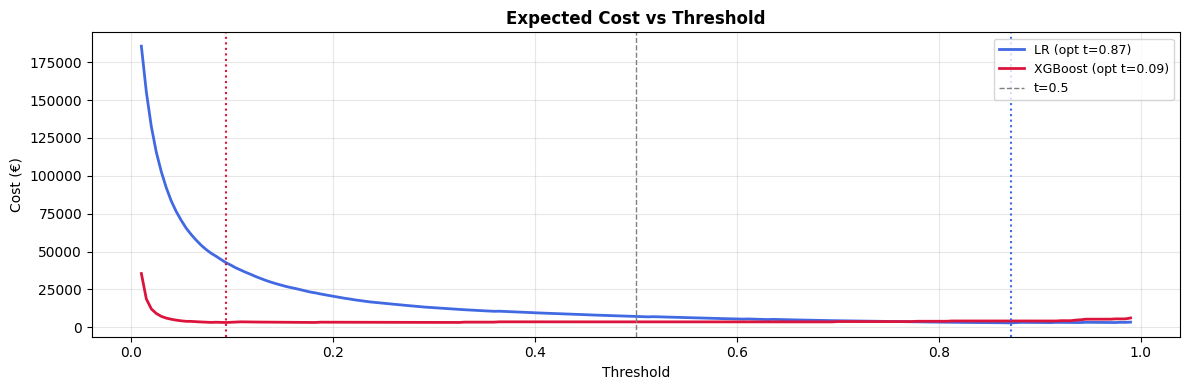


Optimal threshold costs:
  LR  @ t=0.87  → €2,965
  XGB @ t=0.09  → €3,220


In [6]:
FRAUD_LOSS = 200   # € per missed fraud (FN)
FP_COST    = 5     # € per false alert  (FP)

def compute_cost(y_true, y_pred, fraud_loss=FRAUD_LOSS, fp_cost=FP_COST):
    tn_, fp_, fn_, tp_ = confusion_matrix(y_true, y_pred).ravel()
    return (fn_ * fraud_loss) + (fp_ * fp_cost), fn_, fp_, tp_, tn_

lr_cost,  fn_lr,  fp_lr,  tp_lr,  tn_lr   = compute_cost(y_te, lr_pred)
xgb_cost, fn_xgb, fp_xgb, tp_xgb, tn_xgb = compute_cost(y_te, xgb_pred)

print(f"Cost @ threshold=0.5  (FN×€{FRAUD_LOSS} + FP×€{FP_COST})")
print(f"  LR  : €{lr_cost:,.0f}   FN={fn_lr}  FP={fp_lr}")
print(f"  XGB : €{xgb_cost:,.0f}   FN={fn_xgb}  FP={fp_xgb}")
print(f"  Savings: €{lr_cost - xgb_cost:,.0f}")

# threshold sweep
thresholds = np.linspace(0.01, 0.99, 200)

def cost_curve(y_true, y_proba):
    return np.array([compute_cost(y_true, (y_proba >= t).astype(int))[0] for t in thresholds])

lr_costs  = cost_curve(y_te, lr_proba)
xgb_costs = cost_curve(y_te, xgb_proba)

lr_opt_t  = thresholds[np.argmin(lr_costs)]
xgb_opt_t = thresholds[np.argmin(xgb_costs)]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(thresholds, lr_costs,  label=f"LR (opt t={lr_opt_t:.2f})",    color="royalblue", lw=2)
ax.plot(thresholds, xgb_costs, label=f"XGBoost (opt t={xgb_opt_t:.2f})", color="crimson", lw=2)
ax.axvline(0.5, color="gray", linestyle="--", lw=1, label="t=0.5")
ax.axvline(lr_opt_t,  color="royalblue", linestyle=":", lw=1.5)
ax.axvline(xgb_opt_t, color="crimson",   linestyle=":", lw=1.5)
ax.set_title("Expected Cost vs Threshold", fontweight="bold")
ax.set_xlabel("Threshold"); ax.set_ylabel("Cost (€)")
ax.legend(fontsize=9); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("data/processed/cost_vs_threshold.png", dpi=150, bbox_inches="tight")
plt.show()

lr_opt_cost,  *_ = compute_cost(y_te, (lr_proba  >= lr_opt_t).astype(int))
xgb_opt_cost, *_ = compute_cost(y_te, (xgb_proba >= xgb_opt_t).astype(int))
print(f"\nOptimal threshold costs:")
print(f"  LR  @ t={lr_opt_t:.2f}  → €{lr_opt_cost:,.0f}")
print(f"  XGB @ t={xgb_opt_t:.2f}  → €{xgb_opt_cost:,.0f}")


## Step 6 — Feature Importance & SHAP

**XGBoost gain importance** ranks features by their average contribution to reducing loss across all trees.  
**SHAP (TreeExplainer)** gives each feature a directional attribution for every prediction, providing a more faithful and interpretable picture than gain importance alone.

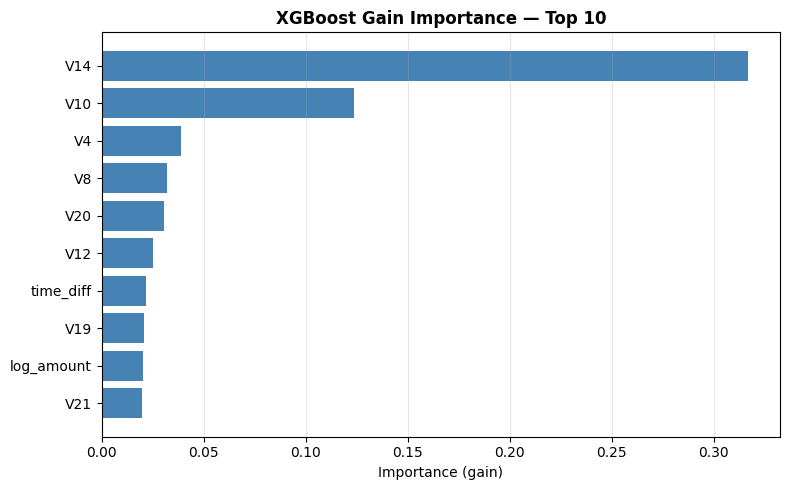

   feature  importance
       V14    0.316738
       V10    0.123595
        V4    0.038782
        V8    0.031847
       V20    0.030467
       V12    0.025112
 time_diff    0.021633
       V19    0.020719
log_amount    0.020417
       V21    0.020017


In [7]:
TOP_N = 10

imp_df = (
    pd.DataFrame({"feature": FEATURE_COLS, "importance": xgb_model.feature_importances_})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(8, 5))
top_imp = imp_df.head(TOP_N)
ax.barh(top_imp["feature"][::-1], top_imp["importance"][::-1], color="steelblue")
ax.set_title(f"XGBoost Gain Importance — Top {TOP_N}", fontweight="bold")
ax.set_xlabel("Importance (gain)")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print(imp_df.head(TOP_N).to_string(index=False))


Computing SHAP values on 2,000 samples …
Done.


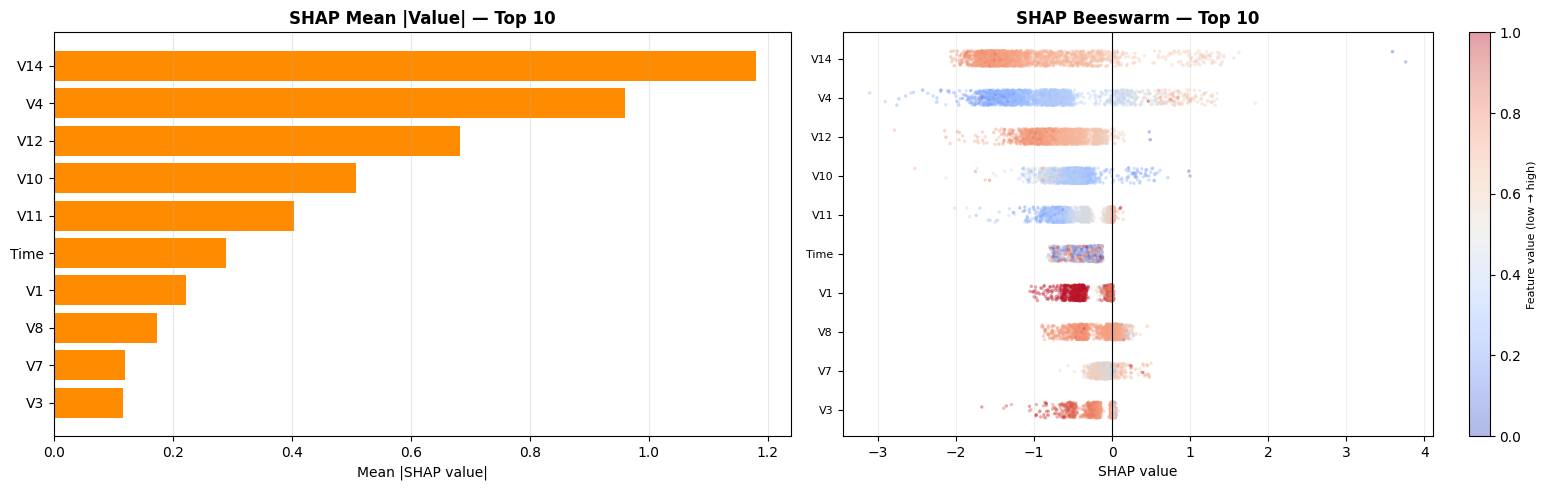


Top 10 by mean |SHAP|:
feature  mean_shap
    V14   1.179745
     V4   0.959835
    V12   0.683458
    V10   0.508286
    V11   0.403795
   Time   0.290043
     V1   0.222215
     V8   0.174264
     V7   0.119110
     V3   0.115975


In [8]:
import shap

explainer = shap.TreeExplainer(xgb_model)

# stratified sample for SHAP — keep fraud/legit ratio roughly intact
SHAP_SAMPLE = min(2000, len(X_test_fe))
rng         = np.random.default_rng(42)
fraud_idx   = np.where(y_te == 1)[0]
legit_idx   = np.where(y_te == 0)[0]
n_fraud     = min(len(fraud_idx), int(SHAP_SAMPLE * y_te.mean()) + 1)
sample_idx  = np.concatenate([
    rng.choice(fraud_idx, n_fraud, replace=False),
    rng.choice(legit_idx, SHAP_SAMPLE - n_fraud, replace=False),
])

X_shap = X_test_fe.iloc[sample_idx].reset_index(drop=True)
print(f"Computing SHAP values on {len(X_shap):,} samples …")
shap_values = explainer.shap_values(X_shap)
print("Done.")

mean_abs_shap = (
    pd.DataFrame({"feature": FEATURE_COLS, "mean_shap": np.abs(shap_values).mean(axis=0)})
    .sort_values("mean_shap", ascending=False)
    .reset_index(drop=True)
)
top_shap      = mean_abs_shap.head(TOP_N)
top_feat_names = top_shap["feature"].tolist()
top_feat_idx   = [FEATURE_COLS.index(f) for f in top_feat_names]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# mean |SHAP| bar
axes[0].barh(top_shap["feature"][::-1], top_shap["mean_shap"][::-1], color="darkorange")
axes[0].set_title(f"SHAP Mean |Value| — Top {TOP_N}", fontweight="bold")
axes[0].set_xlabel("Mean |SHAP value|")
axes[0].grid(axis="x", alpha=0.3)

# beeswarm (matplotlib, no shap.plots dependency)
shap_top   = shap_values[:, top_feat_idx]
X_shap_top = X_shap[top_feat_names]
for i, feat in enumerate(reversed(top_feat_names)):
    fi  = top_feat_names.index(feat)
    sv  = shap_top[:, fi]
    fv  = X_shap_top[feat].values
    fv_norm = (fv - fv.min()) / (fv.max() - fv.min() + 1e-9)
    sc  = axes[1].scatter(
        sv, np.full_like(sv, i) + rng.uniform(-0.2, 0.2, len(sv)),
        c=fv_norm, cmap="coolwarm", alpha=0.4, s=6, linewidths=0,
    )
axes[1].set_yticks(range(TOP_N))
axes[1].set_yticklabels(list(reversed(top_feat_names)), fontsize=8)
axes[1].axvline(0, color="black", lw=0.8)
axes[1].set_title(f"SHAP Beeswarm — Top {TOP_N}", fontweight="bold")
axes[1].set_xlabel("SHAP value")
plt.colorbar(sc, ax=axes[1]).set_label("Feature value (low → high)", fontsize=8)
axes[1].grid(axis="x", alpha=0.2)

plt.tight_layout()
plt.savefig("data/processed/shap_summary.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nTop {TOP_N} by mean |SHAP|:")
print(top_shap.to_string(index=False))


## Summary — Model Comparison Table

In [9]:
results = pd.DataFrame({
    "Metric": [
        "ROC-AUC",
        "PR-AUC",
        f"Recall @ {TARGET_FPR*100:.0f}% FPR",
        f"Precision @ {TARGET_FPR*100:.0f}% FPR",
        "F1 (t=0.5)",
        "Cost € (t=0.5)",
        "Cost € (opt t)",
    ],
    "Logistic Regression": [
        f"{lr_roc_auc:.4f}", f"{lr_pr_auc:.4f}",
        f"{lr_rec_fpr:.4f}", f"{lr_prec_fpr:.4f}", f"{f1:.4f}",
        f"€{lr_cost:,.0f}", f"€{lr_opt_cost:,.0f}  (t={lr_opt_t:.2f})",
    ],
    "XGBoost": [
        f"{xgb_roc_auc:.4f}", f"{xgb_pr_auc:.4f}",
        f"{xgb_rec_fpr:.4f}", f"{xgb_prec_fpr:.4f}", f"{f1_x:.4f}",
        f"€{xgb_cost:,.0f}", f"€{xgb_opt_cost:,.0f}  (t={xgb_opt_t:.2f})",
    ],
})

print(results.to_string(index=False))
print(f"\nFN×€{FRAUD_LOSS} + FP×€{FP_COST}")


            Metric Logistic Regression          XGBoost
           ROC-AUC              0.9861           0.9681
            PR-AUC              0.7597           0.7942
   Recall @ 1% FPR              0.8667           0.8667
Precision @ 1% FPR              0.0893           0.0409
        F1 (t=0.5)              0.1045           0.8143
    Cost € (t=0.5)              €7,195           €3,640
    Cost € (opt t)    €2,965  (t=0.87) €3,220  (t=0.09)

FN×€200 + FP×€5
